# Cracking the Code of Glioblastoma Progression

This project aims to create a proof of concept for survival prediction using machine learning models applied to the LUMIERE dataset, which includes longitudinal glioblastoma MRI scans, clinical data, and expert evaluations. The project focuses on experimenting with models such as the Cox proportional hazards model and Random Survival Forest (RSF) to evaluate their effectiveness in predicting survival times. This work serves as a foundational step toward developing a tool for clinicians that combines patient data and MRI images to offer precise, interpretable survival predictions. Key challenges tackled include extensive data preprocessing, feature engineering, and initial model implementation. While the results achieved are preliminary, they provide valuable insights and a platform for future improvements, including integrating MRI data and optimizing model performance.


## Background information
### Glioblastoma
Glioblastoma is a type of brain cancer that is known for being one of the most aggressive and lethal forms of it. It is a primary brain tumor that originates from the brain's glial cells, which are the supportive tissue of the brain. The World Health Organization (WHO) classifies glioblastoma as a grade IV tumor, indicating that it is a high-grade tumor. Glioblastoma is characterized by its rapid growth and ability to invade surrounding brain tissue, making it difficult to treat. The standard treatment for glioblastoma typically involves surgery to remove as much of the tumor as possible, followed by radiation therapy and chemotherapy. Despite these treatments, glioblastoma has a poor prognosis, with a median survival time of approximately 15-18 months after diagnosis. Therefore, accurate survival prediction is crucial for patients with glioblastoma, as it can help guide treatment decisions and improve patient outcomes.

### What genes are connected to the development of the Glioblastoma?
**The MGMT gene**  
MGMT (O6-methylguanine-DNA-methyltransferase) is a tumor-suppressor gene that regulates the repair of DNA damage. The gene has been identified as an important factor in the treatment of glioblastoma, an aggressive form of brain tumor. The MGMT methyltransferase is an enzyme that has DNA methyltransferase function, allowing it to repair DNA damage. When the MGMT gene is silenced, DNA cannot be repaired, which can lead to genetic mutations and tumor development.

#### The IDH gene  
IDH (Isocitrate Dehydrogenase) refers to a family of enzymes involved in cellular metabolism, specifically in the Krebs cycle, where they catalyze the conversion of isocitrate to α-ketoglutarate. Mutations in the IDH1 and IDH2 genes are frequently observed in certain types of brain tumors, including gliomas and glioblastomas. These mutations lead to the production of an abnormal metabolite called 2-hydroxyglutarate (2-HG), which disrupts normal cell functions and promotes tumor growth.
The IDH gene mutations are significant in glioblastoma research because they are associated with better prognosis and response to treatment compared to glioblastomas without these mutations. This makes IDH an important biomarker for diagnosis, prognosis, and the development of targeted therapies.


### The LUMIERE Dataset: Longitudinal Glioblastoma MRI with Expert RANO Evaluation
The LUMIERE dataset is a collection of MRI scans of patients with glioblastoma, along with their corresponding clinical data and expert evaluations. The dataset is designed to support the development of machine learning models for glioblastoma diagnosis and survival prediction. The LUMIERE dataset includes an extensive range of MRI scans, including preoperative, postoperative, and follow-up scans, which provide valuable information about the tumor's growth and response to treatment. The dataset also includes expert evaluations of the MRI scans, which are based on the Response Assessment in Neuro-Oncology (RANO) criteria . The RANO criteria are a widely accepted standard for evaluating the response of glioblastoma to treatment. The LUMIERE dataset is a valuable resource for researchers and clinicians who are interested in developing and evaluating machine learning models for glioblastoma diagnosis and survival prediction. 

___
## Imports

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
import json
from pathlib import Path
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from lifelines import CoxPHFitter

___
## Data loading
To show what the data looks like and consists of a short EDA has been used to do a quick analysis of the data. The different files with data are loaded into a pandas dataframes and at the end made into 1 to export to a csv file making it that the files wont have to be rerun everytime this notebook is run. Instead the file made by me will be used and loaded into a dataframe. 

The data is loaded from the following files:
- "LUMIERE-Demographics_Pathology.csv" (Pathology data)
- "LUMIERE-ExpertRating-v202211.csv" (Rating data)
- "Images.zip" This is where all the tumor volumes are, they are seperrated by patient AND time. The path is patient\week\DeepBraTumIA-segmentation\atlas\segmentation\measured_volumes_in_mm3.json and has 3 type of volumes: Necrotic_NonEnhancing for dead tissue, Enhancing_Core for active tumor tissue and Edema_Compartment for swelling and moisture accumulation.

In [3]:
# Make an Datframe from pathology data
df_pathology = pd.read_csv("LUMIERE-Demographics_Pathology.csv")

In [4]:
# Make an dataframe from de rating data
df_rating = pd.read_csv("LUMIERE-ExpertRating-v202211.csv")
df_rating


,Patient,Date,LessThan3Months,NonMeasurableLesions,"Rating (according to RANO, PD: Progressive disease, SD: Stable disease, PR: Partial response, CR: Complete response, Pre-Op: Pre-Operative, Post-Op: Post-Operative)","Rating rationale (CRET: complete resection of the enhancing tumor, PRET: partial resection of the enhancing tumor, T2-Progr.: T2-Progression, L: Lesion)"
0,Patient-001,week-000-1,NaN,NaN,Pre-Op,NaN
1,Patient-001,week-000-2,NaN,NaN,Post-Op,CRET
2,Patient-001,week-044,NaN,NaN,SD,NaN
3,Patient-001,week-056,NaN,x,PD,"Target L.: 1 12mm x 13mm, new non-target L."
4,Patient-002,week-000,NaN,NaN,Pre-Op,NaN
...,...,...,...,...,...,...
611,Patient-091,week-001,NaN,NaN,Post-Op,PRET
612,Patient-091,week-014,NaN,x,PD,Non-measurable L.
613,Patient-091,week-026,NaN,x,PD,Non-measurable L.
614,Patient-091,week-036,NaN,x,PD,Non-measurable L.


In [5]:
# # Initialize a list to store the data and a counter for missing files
# data = []
# missing_files_count = 0

# # Loop through each row in the DataFrame
# for index, row in df_rating.iterrows():
#     patient = row['Patient']
#     week = row['Date']
    
#     # Construct the file path using pathlib
#     file_path = Path('Imaging') / patient / week / 'DeepBraTumIA-segmentation' / 'atlas' / 'segmentation' / 'measured_volumes_in_mm3.json'
    
#     # Check if the file exists
#     if file_path.exists():
#         try:
#             # Read the JSON file
#             with open(file_path, 'r') as f:
#                 json_data = json.load(f)
            
#             # Extract the relevant volume data
#             necrotic_non_enhancing = json_data.get('Necrotic_NonEnhancing', None)
#             enhancing_core = json_data.get('Enhancing_Core', None)
#             edema_compartment = json_data.get('Edema_Compartment', None)
            
#             # Append the data to the list
#             data.append({
#                 'Patient': patient,
#                 'Week': week,
#                 'Necrotic_NonEnhancing': necrotic_non_enhancing,
#                 'Enhancing_Core': enhancing_core,
#                 'Edema_Compartment': edema_compartment,
#                 'LessThan3Months': row['LessThan3Months'],
#                 'NonMeasurableLesions': row['NonMeasurableLesions'],
#                 'Rating': row['Rating (according to RANO, PD: Progressive disease, SD: Stable disease, PR: Partial response, CR: Complete response, Pre-Op: Pre-Operative, Post-Op: Post-Operative)'],
#                 'RatingRationale': row['Rating rationale (CRET: complete resection of the enhancing tumor, PRET: partial resection of the enhancing tumor, T2-Progr.: T2-Progression, L: Lesion)']
#             })
#         except json.JSONDecodeError:
#             print(f"Error decoding JSON: {file_path}")
#     else:
#         # Increment the counter for missing files
#         missing_files_count += 1

# # Create a new DataFrame from the collected data
# df_measured_volumes = pd.DataFrame(data)

# # Display the summary statistics
# print(f"Total missing files: {missing_files_count}")
# print(f"DataFrame shape: {df_measured_volumes.shape}")

Intotal there are 47 weeks without the file "measured_volumes_in_mm3.json" so those weeks are skipped.

Code to merge the three dataframes into a single dataframe.

In [6]:
# # Merge the two DataFrames on the 'Patient' column
# df_combined = pd.merge(df_measured_volumes, df_pathology, on='Patient', how='left')
# df_combined.to_csv("df_combined.csv", sep=";", index=False)

In [7]:
# Reads in the made combined dataset and makes an datafrane of it
df_combined = pd.read_csv("df_combined.csv", sep=";")

# Clean column names
df_combined.columns = df_combined.columns.str.strip().str.replace(' ', '_').str.lower()

# add NonMeasurableLesions and LessThan3Months from df_rating to df_combined
df_combined['NonMeasurableLesions'] = df_rating['NonMeasurableLesions']
df_combined['LessThan3Months'] = df_rating['LessThan3Months']

___
## EDA
### Univariaat  
This document contains the basic information of the patients. Lets take a look what we have.

We start of by getting this overview of all possible columns with some insight into what is contained in the file.

In [8]:
df_pathology.nunique()

Patient                   91
Survival time (weeks)     65
Sex                        2
Age at surgery (years)    37
IDH (WT: wild type)        5
IDH method                 4
MGMT qualitative           3
MGMT quantitative         19
dtype: int64

In [9]:
df_pathology.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Patient                 91 non-null     object
 1   Survival time (weeks)   91 non-null     object
 2   Sex                     91 non-null     object
 3   Age at surgery (years)  91 non-null     int64 
 4   IDH (WT: wild type)     91 non-null     object
 5   IDH method              91 non-null     object
 6   MGMT qualitative        91 non-null     object
 7   MGMT quantitative       91 non-null     object
dtypes: int64(1), object(7)
memory usage: 5.8+ KB


In [10]:
df_pathology.head()

,Patient,Survival time (weeks),Sex,Age at surgery (years),IDH (WT: wild type),IDH method,MGMT qualitative,MGMT quantitative
0,Patient-001,89,female,57,WT,BES,methylated,na
1,Patient-002,48,female,71,na,na,not methylated,0.00%
2,Patient-003,40,male,39,WT,Immuno,not methylated,0.00%
3,Patient-004,110,male,69,WT,Sanger Sequencing,not methylated,0.00%
4,Patient-005,53,male,66,WT,Immuno,not methylated,0.00%


From the .info() and .describe() it came back that some were objects while there was a lot of unique numbers and looking at the first 5 rows of the data it is clear it should be intergers or floats so this code is to replace them.


In [11]:
listy = []
for j in df_pathology["MGMT quantitative"]:
    if j == 'na':
        listy.append(np.nan)
    else:
        j = j.split("%")[0]
        listy.append(float(j))

df_pathology["MGMT quantitative"] = listy
df_pathology["Survival time (weeks)"] = pd.to_numeric(df_pathology["Survival time (weeks)"], errors='coerce')
df_pathology.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Patient                 91 non-null     object 
 1   Survival time (weeks)   86 non-null     float64
 2   Sex                     91 non-null     object 
 3   Age at surgery (years)  91 non-null     int64  
 4   IDH (WT: wild type)     91 non-null     object 
 5   IDH method              91 non-null     object 
 6   MGMT qualitative        91 non-null     object 
 7   MGMT quantitative       64 non-null     float64
dtypes: float64(2), int64(1), object(5)
memory usage: 5.8+ KB


From the top two code chunks, there is a lot of information about the structure of the data. There are 91 patients in the data. To keep the rest organized, it is summarized in a table below: 

In [12]:
codebook={
    "attribute": ['Patient_number', 'Survival_time', 'Sex', 'Age at surgery', 'IDH', 'IDH method', 'MGMT qualitative', 'MGMT quantitative'],
    "unit": ["n.a.", "weeks.", "n.a.", "years", "n.a.", "n.a.", "n.a.", "%"],
    "dtype": ["category", "float64", "category", "int64", "catergory", "catergory", "category", "float64"],
    "description": [
        "Patient number for anonomisty", 
        "Amount of weeks the patient survived after surgery", 
        "The sex of the patient", 
        "The age the patient was when the surgery was preformed", 
        "Tells if the patient has the wild type or a mutation of the Isocitrate DeHydrogenase gene", 
        "What method was used for identifying IDH", 
        "If the O6-methylguanine-DNA-methyltransferase(MGMT) was in a methylated, non-methylated or unknown state",
        "The percentage of the MGMT gene that was methylated"
    ]
}
pd.DataFrame(codebook).set_index("attribute")

,unit,dtype,description
attribute,,,
Patient_number,n.a.,category,Patient number for anonomisty
Survival_time,weeks.,float64,Amount of weeks the patient survived after sur...
Sex,n.a.,category,The sex of the patient
Age at surgery,years,int64,The age the patient was when the surgery was p...
IDH,n.a.,catergory,Tells if the patient has the wild type or a mu...
IDH method,n.a.,catergory,What method was used for identifying IDH
MGMT qualitative,n.a.,category,If the O6-methylguanine-DNA-methyltransferase(...
MGMT quantitative,%,float64,The percentage of the MGMT gene that was methy...


The following code it to get an overview how the numeral data is divided:

In [13]:
df_pathology.describe()

,Survival time (weeks),Age at surgery (years),MGMT quantitative
count,86.000000,91.000000,64.000000
mean,83.395349,62.197802,25.593750
std,47.409674,10.340019,39.182406
min,3.000000,39.000000,0.000000
25%,50.000000,54.500000,0.000000
50%,72.500000,63.000000,0.000000
75%,116.750000,70.500000,73.500000
max,201.000000,80.000000,100.000000


It seems like the the survival time and MGMT quantitative varies a lot but the age category seems to be mostly between 54 and 70 which is not a big age gap. To vissually show it, i made the plot below.

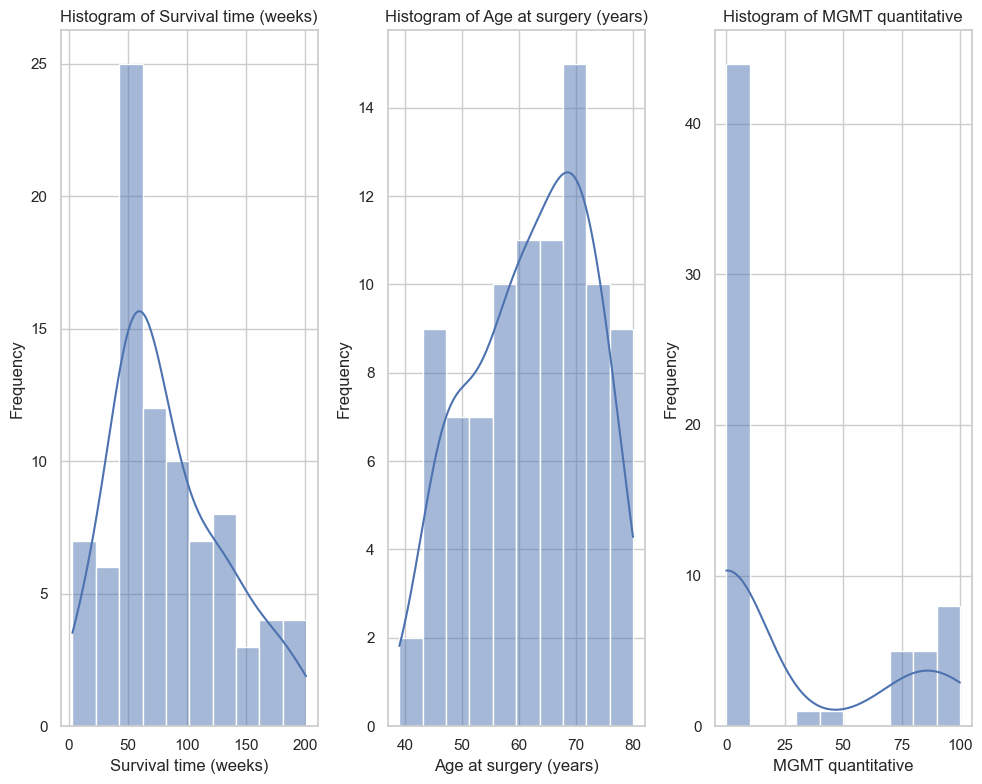

In [14]:
# violin plot or histogram of the data
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

list_columns = ['Survival time (weeks)', 'Age at surgery (years)', 'MGMT quantitative']
for i, column in enumerate(list_columns):
    sns.histplot(data=df_pathology, x=column, ax=axes[i], kde=True, bins=10)
    axes[i].set_title(f"Histogram of {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

The survival weeks is as expected because there is a peak at 50-80 months, just like it says in the litterature. De age at surgery is as described by the code above almost all the patients between 55 and 75. For MGMT there is a lot of zeros, this might be because a lot of patiënts didnt get the test done.  

To also show the frequentie of the object columns the following code is used:

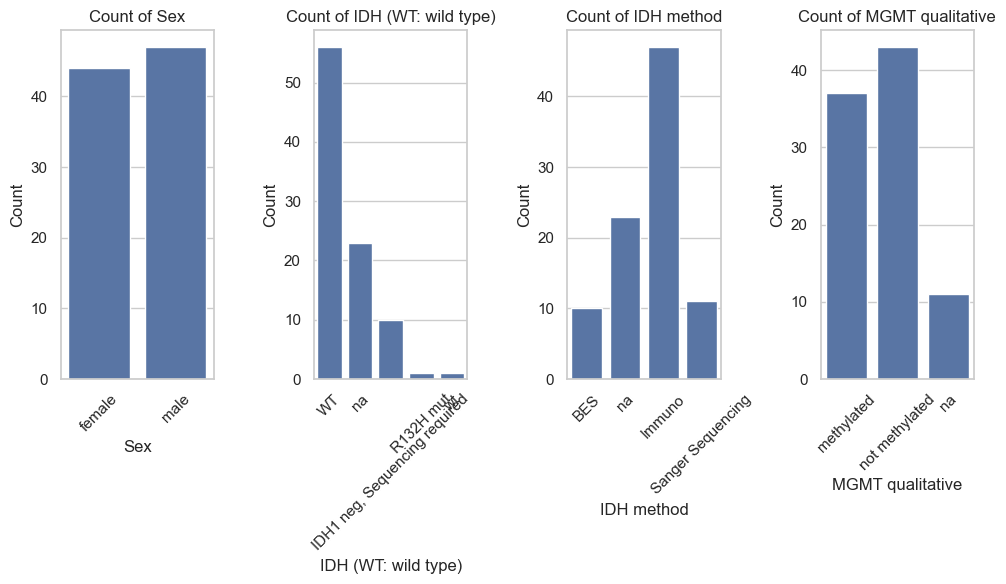

In [15]:
# barplots for Sex, IDH (WT: wild type), IDH method, MGMT qualitative
# grid of 2 by 2
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 6))

list_columns = ['Sex', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative']
for i, column in enumerate(list_columns):
    sns.countplot(data=df_pathology, x=column, ax=axes[i])
    axes[i].set_title(f'Count of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The sex of the patiënts is almost 50/50 with a small lean to the males. Also can be seen that a lot of the patients have a WildType of the IDH gene which means that most of the patiënt have a worstend prognosis. The IDH method is a lot higher in immuno. MGMT qualitative is almost 50/50 with methylated or not.   
As can be seen by almost very graph the is lot of na values and later in the other documnet aswell, I solved it by using one-hot encoding before making the step to training the models.

___
### The Expert Rating dataset
We start of the same way as before and take a look at the overview of the data:

In [19]:
df_rating.nunique()

Patient                                                                                                                                                                  91
Date                                                                                                                                                                    159
LessThan3Months                                                                                                                                                           1
NonMeasurableLesions                                                                                                                                                      1
Rating (according to RANO, PD: Progressive disease, SD: Stable disease, PR: Partial response, CR: Complete response, Pre-Op: Pre-Operative, Post-Op: Post-Operative)      8
Rating rationale (CRET: complete resection of the enhancing tumor, PRET: partial resection of the enhancing tumor, T2-Progr.: T2-Progression

In [20]:
df_rating.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 6 columns):
 #   Column                                                                                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                                                                                --------------  ----- 
 0   Patient                                                                                                                                                               616 non-null    object
 1   Date                                                                                                                                                                  616 non-null    object
 2   LessThan3Months                                                                                                    

From this, it becomes clear that LessThan3Months and NonMeasurableLesions both have only one value, namely x, in addition to NaN, which is not included in the count() function. Therefore, it should actually return 2. One option is to hot encode it or just cahnge it to 0 and 1(false and true respectively). An other thing like before every thing is an object instead of numeric. So we need to convert most of it to numeric.

In [21]:
# data processing
# catergory to integers
df_rating["LessThan3Months"] = df_rating["LessThan3Months"].apply(lambda x: 1 if x == "x" else 0)
df_rating["NonMeasurableLesions"] = df_rating["NonMeasurableLesions"].apply(lambda x: 1 if x == "x" else 0)

# replace column names
df_rating.columns = ["Patient", "Date", "LessThan3Months", "NonMeasurableLesions", "Rating", "Rationale_rating"]
df_rating.describe()


,LessThan3Months,NonMeasurableLesions
count,616.000000,616.000000
mean,0.045455,0.071429
std,0.208468,0.257749
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


Codebook for this rating file, providing a convenient reference for understanding the contents of each column.

In [22]:
codebook={
    "attribute": ['Patient', 'Date', 'LessThan3Months', 'NonMeasurableLesions', 'Rating', 'Rationale_rating'],
    "unit": ["n.a.", "week", "n.a.", "n.a.", "n.a.", "n.a."],
    "dtype": ["category", "category", "category", "category", "catergory", "catergory"],
    "description": [
        "Patient number for anonomisty", 
        "The week when the MRI was taken", 
        "If the tumor came back within 3 months", 
        "Sometimes an new lesion can not be measured yet", 
        "Catergory of tumor(s). PD: Progressive disease, SD: Stable disease, PR: Partial response, CR: Complete response, Pre-Op: Pre-Operative, Post-Op: Post-Operative.", 
        "CRET: complete resection of the enhancing tumor, PRET: partial resection of the enhancing tumor, T2-Progr.: T2-Progression, L: Lesion"
    ]
}
pd.DataFrame(codebook).set_index("description")

,attribute,unit,dtype
description,,,
Patient number for anonomisty,Patient,n.a.,category
The week when the MRI was taken,Date,week,category
If the tumor came back within 3 months,LessThan3Months,n.a.,category
Sometimes an new lesion can not be measured yet,NonMeasurableLesions,n.a.,category
"Catergory of tumor(s). PD: Progressive disease, SD: Stable disease, PR: Partial response, CR: Complete response, Pre-Op: Pre-Operative, Post-Op: Post-Operative.",Rating,n.a.,catergory
"CRET: complete resection of the enhancing tumor, PRET: partial resection of the enhancing tumor, T2-Progr.: T2-Progression, L: Lesion",Rationale_rating,n.a.,catergory


The following three code chunks present visualizations for the various columns of the DataFrame.

We will start with the column indicating when the MRI was taken. First, we will convert the data from string format to integers.

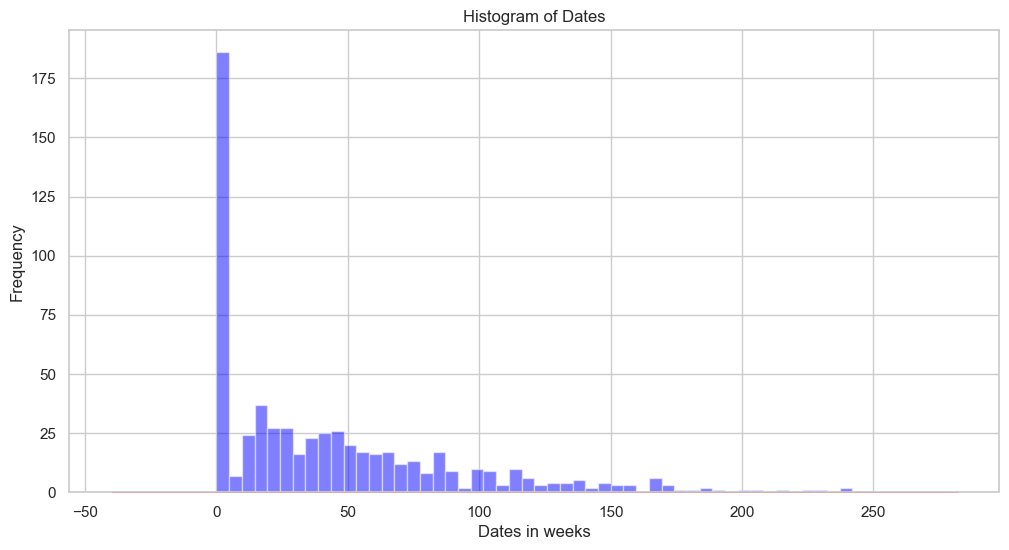

In [23]:
# Extract week numbers as integers
data = [int(week.split('-')[1]) for week in df_rating['Date']]

# Set the style of the visualization
sns.set(style="whitegrid")

# Create a histogram with adjusted bin width and transparency
plt.figure(figsize=(12, 6))
plt.hist(data, bins=50, alpha=0.5, color='blue', label='Histogram')

# Overlay a density plot
sns.kdeplot(data, color='red', label='Density Plot', fill=True)

plt.title('Histogram of Dates')
plt.xlabel('Dates in weeks')
plt.ylabel('Frequency')
plt.show()

It is evident that the majority of cases occur within the first week before or after the operation. Gradually, the numbers decline, reaching around 100, which seems reasonable since most patients do not survive beyond 50 to 80 weeks. There are still a few cases remaining; this may be due to the fact that the 50 to 80-week period often coincides with the diagnosis, following nearly complete tumor removal through surgery.

C:\Users\aimee\AppData\Local\Temp\ipykernel_39668\1305707157.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rating, x=column, palette='Set2', ax=axes[i])
C:\Users\aimee\AppData\Local\Temp\ipykernel_39668\1305707157.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rating, x=column, palette='Set2', ax=axes[i])
C:\Users\aimee\AppData\Local\Temp\ipykernel_39668\1305707157.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rating, x=column, palette='Set2', ax=axes[i])


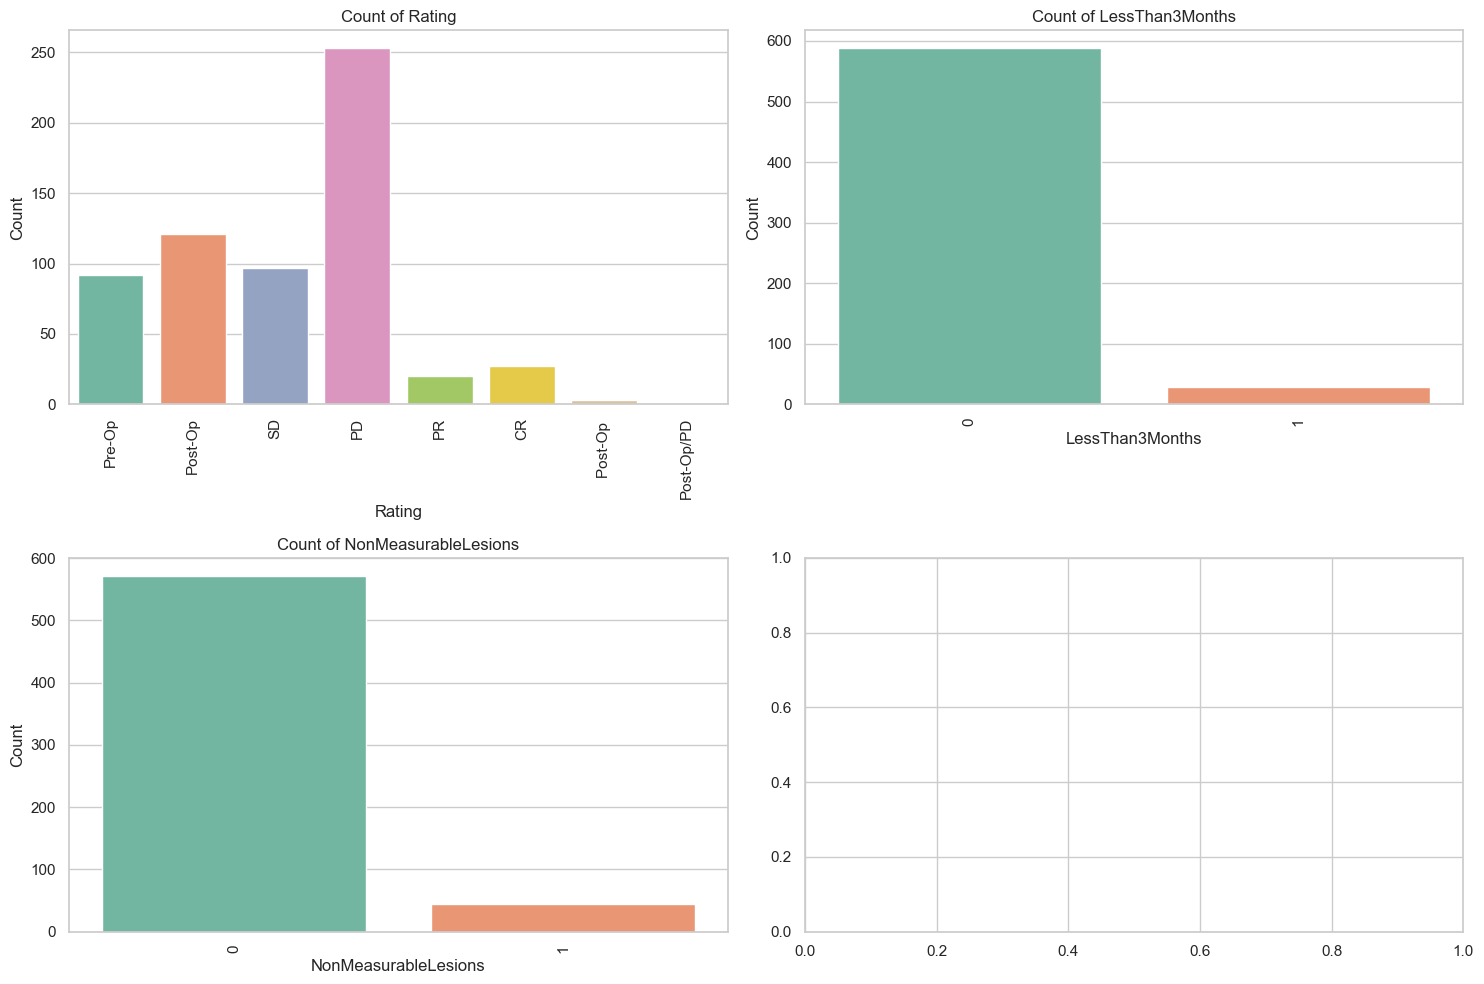

In [24]:
# een barplot voor Rating, Rating rationale, lessTha3Months, NonMeasurableLesions
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
list_columns = ['Rating', 'LessThan3Months', 'NonMeasurableLesions']

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the columns and create count plots
for i, column in enumerate(list_columns):
    sns.countplot(data=df_rating, x=column, palette='Set2', ax=axes[i])
    axes[i].set_title(f'Count of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis labels for better readability

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Graph 1: Count of Rating: This graph shows the frequency of different "Rating" values. The most frequent value is "PD", followed by "Post-Op", then "SD". All other values have very low frequency. 

Graph 2: Count of LessThan3Months: This graph shows the frequency of values in a variable called "LessThan3Months". The most frequent value is "0" with "1" having a very low frequency. This points to that there is not a big chance of the tumor growing back within the first 3 months after the surgery.

Graph 3: Count of NonMeasurableLesions: This graph shows the frequency of values in a variable called "NonMeasurableLesions". The most frequent value is "0" with "1" having a very low frequency. This points to that most of the time the tumor is measurable at any time.

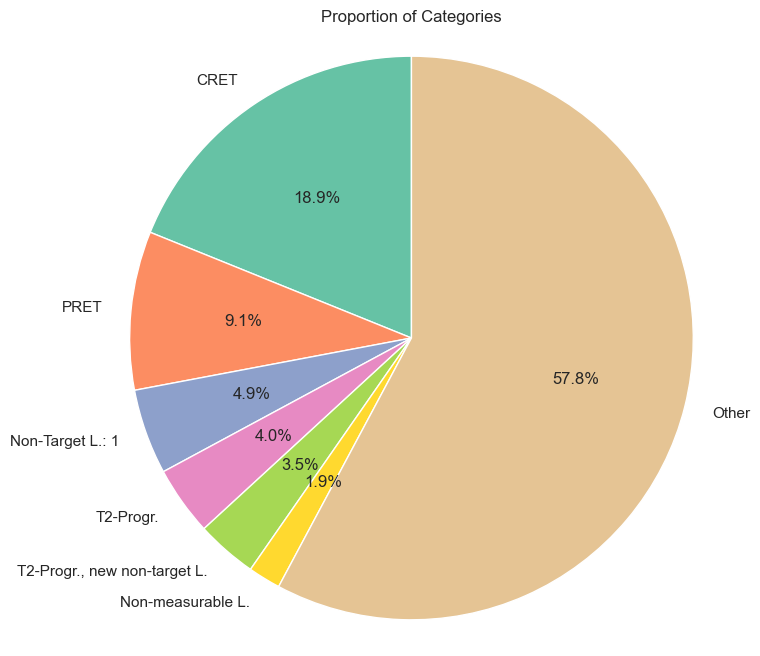

In [25]:
# Calculate the frequencies
category_counts = df_rating["Rationale_rating"].value_counts()

# Calculate percentages for filtering
total_count = category_counts.sum()
percentages = (category_counts / total_count) * 100

# Separate small categories and calculate their total
small_categories = category_counts[percentages < 1.8]
small_categories_total = small_categories.sum()

# Filter out the small categories from the main dataset
filtered_counts = category_counts[percentages >= 1.8]

# Add "Other" category for small categories
filtered_counts["Other"] = small_categories_total

# Custom autopct function to filter smaller percentages
def custom_autopct(pct):
    return f'{pct:.1f}%' if pct > 1.8 else ''  # Show percentages > 1.8%

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    filtered_counts, 
    labels=filtered_counts.index,  # Use labels with "Other" included
    autopct=custom_autopct,  # Use the custom autopct function
    startangle=90, 
    colors=sns.color_palette('Set2', len(filtered_counts))
)
plt.title('Proportion of Categories')
plt.axis('equal')  # Ensure the pie chart is circular
plt.show()


The pie chart shows the proportion of different categories observed in a study, highlighting that the majority of cases fall under CRET (18.9%) and PRET (9.1%). The remaining categories, including Non-Target L, T2-Progr, Non-measurable L, Target, and others, are observed in smaller proportions. In the other category are the ones less than 1.8% of the total.

___
Finally, to understand how the different tumor volumes are distributed, we use the describe function and a boxplot to visualize the data for each tumor compartment. The boxplot effectively highlights key statistical features, including the range, median, quartiles, and potential outliers for each compartment. 

Descriptive Statistics:
       necrotic_nonenhancing  edema_compartment  enhancing_core
count             569.000000         569.000000      569.000000
mean            15165.202109       48048.701230     7754.513181
std             19065.620367       38239.723156    12232.695394
min                 0.000000           0.000000        0.000000
25%              1796.000000       18907.000000      335.000000
50%              8142.000000       39230.000000     2676.000000
75%             22009.000000       63814.000000     9098.000000
max            123286.000000      241478.000000    94603.000000


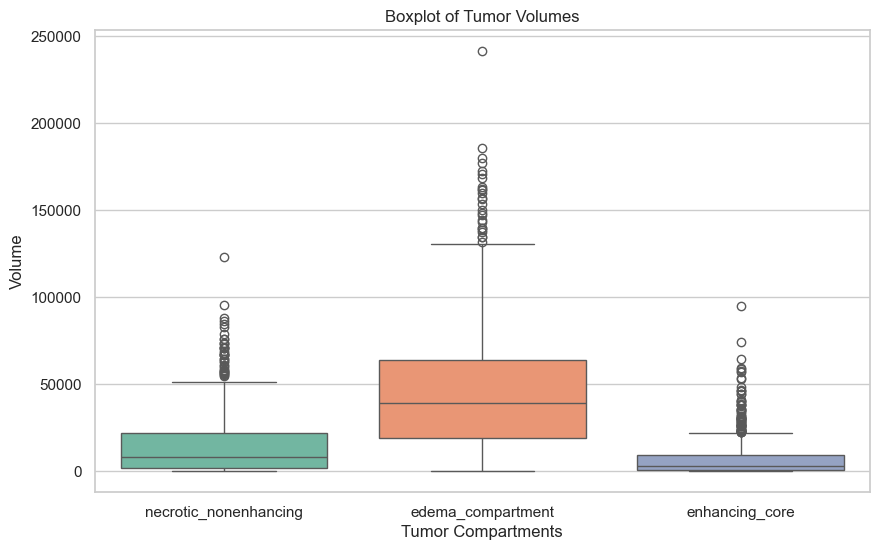

In [26]:
df_tumor = pd.DataFrame()
df_tumor["necrotic_nonenhancing"] = df_combined["necrotic_nonenhancing"]
df_tumor["edema_compartment"] = df_combined["edema_compartment"]
df_tumor["enhancing_core"] = df_combined["enhancing_core"]

print("Descriptive Statistics:")
print(df_tumor.describe())

# Boxplot for each compartment
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_tumor, palette="Set2")
plt.title("Boxplot of Tumor Volumes")
plt.ylabel("Volume")
plt.xlabel("Tumor Compartments")
plt.show()


The tumor volumes vary significantly across different compartments. The edema_compartment has the highest median and average volumes, followed by necrotic_nonenhancing, and enhancing_core has the lowest median and average volumes. There is a notable presence of outliers with very high volumes, especially in the edema_compartment.

___
# Model Design

The models I will be using for survival prediction are based on insights from the literature and personal experience. Each model offers unique strengths for analyzing survival data:

**Cox Proportional Hazards Model:**  
This is a widely used statistical model in survival analysis that examines the relationship between the survival time of subjects and one or more predictor variables. The Cox model assumes that the hazard ratios between different groups remain constant over time, making it suitable for identifying significant covariates that impact survival.

**Random Survival Forest (RSF)**:  
This machine learning approach is an extension of random forests for survival analysis. RSF can handle complex, non-linear relationships and high-dimensional data without requiring proportional hazards assumptions. It is particularly effective for capturing interactions between variables and exploring patterns that might not be apparent with traditional models.

**Kaplan-Meier Model**:  
This non-parametric model estimates survival probabilities over time and is used to visualize survival curves for different groups. The Kaplan-Meier method provides an intuitive way to compare survival distributions and assess differences between groups, such as those with specific mutations or treatment regimens.

Before diving completly into the model training and evaluation, we have to prepare the data. This includes the one hot encoding that was mentioned earlier, only continuing with the columns that i want to use and dividing into train, test and validation sets. See the code below.

In [27]:
# One-hot encode specified columns
one_hot_encoded = pd.get_dummies(
    df_combined[["rating", "sex", "idh_(wt:_wild_type)", "idh_method", "mgmt_qualitative"]],
    prefix=['rating', 'sex', 'idh', 'idh_method', 'mgmt'],
    dummy_na=False
)

# Fill NaN values with 0 and convert to int
one_hot_encoded = one_hot_encoded.fillna(0).astype(int)

# Drop original categorical columns
df = df_combined.drop(columns=["rating", "sex", "idh_(wt:_wild_type)", "idh_method", "mgmt_qualitative"])

# Concatenate the original DataFrame with the one-hot encoded DataFrame
data = pd.concat([df, one_hot_encoded], axis=1)

# Change names to numeric
data["patient"] = pd.to_numeric([i.split("-")[-1] for i in data["patient"]])

# Create `time` column
data['time'] = pd.to_numeric([i.split("-")[1] for i in data['week']])

# Create `event` column
# Event is 0 if survival time (in weeks) is greater than `time` 
# or NaN in the data which means the patient was still alive when the research project had finished
# otherwise 1
data['survival_time_(weeks)'] = data['survival_time_(weeks)'].replace("na", None)
data['event'] = data.apply(
    lambda row: 0 if pd.isna(row['survival_time_(weeks)']) or 
                     (row['survival_time_(weeks)'] is not None and row['time'] >= int(row['survival_time_(weeks)'])) 
               else 1,
    axis=1
)

# Select relevant columns
processed_data = data[['patient', 'necrotic_nonenhancing', 'enhancing_core',
       'edema_compartment', 'age_at_surgery_(years)', 'rating_CR', 'rating_PD',
       'rating_PR', 'rating_Post-Op', 'rating_Post-Op ', 'rating_Post-Op/PD',
       'rating_Pre-Op', 'rating_SD', 'sex_female', 'sex_male',
       'idh_IDH1 neg, Sequencing required', 'idh_R132H mut', 'idh_WT', 'idh_wt', 
       'mgmt_methylated', 'mgmt_not methylated', 'time', 'event']]

# Save processed data to a new file
# processed_data.to_csv("processed_survival_data.csv", index=False)

print(processed_data.head(3))

   patient  necrotic_nonenhancing  enhancing_core  edema_compartment  \
0        1                13262.0         16751.0            43488.0   
1        1                 4557.0          6799.0            32506.0   
2        1                18615.0             5.0            18780.0   

   age_at_surgery_(years)  rating_CR  rating_PD  rating_PR  rating_Post-Op  \
0                      57          0          0          0               0   
1                      57          0          0          0               1   
2                      57          0          0          0               0   

   rating_Post-Op   ...  sex_female  sex_male  \
0                0  ...           1         0   
1                0  ...           1         0   
2                0  ...           1         0   

   idh_IDH1 neg, Sequencing required  idh_R132H mut  idh_WT  idh_wt  \
0                                  0              0       1       0   
1                                  0              0       1

In [28]:
# showing the amount of alive and dead rows
print(processed_data['event'].value_counts())

event
1    526
0     43
Name: count, dtype: int64


So the data consist of 526 rows where the person eventually die and 43 that took longer than the project duration. The data is not balanced. 


To show the corralation between all the columns, we use the following code:

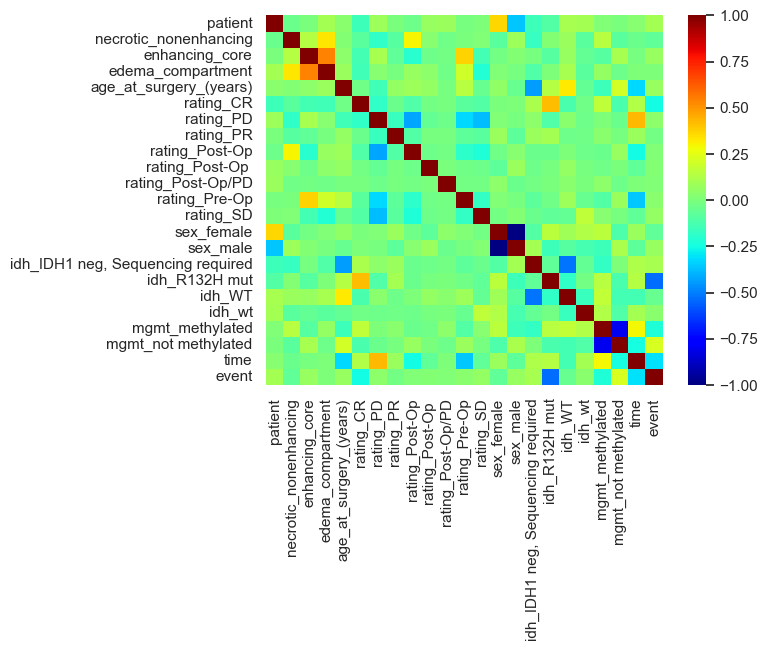

In [29]:
sns.heatmap(processed_data.corr(), cmap="jet", vmin=-1.0, vmax=1.0)
plt.show()

It seems like the edema and enhancing volume are highly correlated. It makes sense that female/male and methylated/non-methylated are negatively correlated. 




In [30]:
# # Train, test , and validation data
X = processed_data.drop(columns=['event', 'time'])  # Exclude non-predictor columns
y = Surv.from_dataframe("event", "time", processed_data)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42) # 80% for training and 20% for testing

## Cox Hazard Regression Model

The first model I explored was the **Cox Proportional Hazards Model**, so let’s start with that. This model is a cornerstone in survival analysis, widely used in medical research and other fields to analyze and predict survival times while accounting for one or more predictor variables.

Lets start at what it is, the Cox model is a semi-parametric statistical approach that estimates the hazard, or the risk of an event (such as death or disease progression), occurring at a given time. What sets it apart is its ability to handle censored data—cases where the event of interest has not yet occurred during the study period. This makes it highly suitable for survival data analysis. [link: ]

Behind the scenes, the Cox model does not assume a specific baseline hazard function. Instead, it focuses on estimating the hazard ratio—the relative difference in hazard between groups—based on predictor variables.  
Mathematically, the hazard is modeled as:  

\[
h(t) = h_0(t) \cdot \exp(\beta_1 X_1 + \beta_2 X_2 + \dots + \beta_p X_p)
\]

Where:  
- \(h(t)\): Hazard at time \(t\)  
- \(h_0(t)\): Baseline hazard (shared by all subjects)  
- \(X_1, X_2, \dots, X_p\): Predictor variables  
- \(\beta_1, \beta_2, \dots, \beta_p\): Coefficients for predictors  

The Cox model estimates these coefficients (\(\beta\)) to quantify the effect of each predictor on survival, while the baseline hazard \(h_0(t)\) is left unspecified.

I chose to include this model for the a few reasons first of it does not require specifying the form of the baseline hazard, making it flexible for a wide range of datasets. And secondly, the hazard ratios it provides are straightforward to interpret, making it easy to identify the impact of variables on survival. And lastly, it can efficiently handle cases where the outcome event hasn’t occurred, preserving valuable information from incomplete observations.

By starting with the Cox model, I aimed to establish a statistical foundation for survival analysis before exploring the other models.


In [31]:
# cph = CoxPHFitter()
# cph.fit(processed_data, duration_col='time', event_col='event', show_progress=True)

# # Summarize the model
# cph.print_summary()

As you can see for this model i am getting an error that my data corralates a lot and that the idh_R132H mut column completly predicts if the patient dies or not. This made me look into VIF and it seems like it is a good way to check for multicollinearity. 

In [32]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif)

                             Variable       VIF
0                             patient  1.263796
1               necrotic_nonenhancing  1.370407
2                      enhancing_core  1.780570
3                   edema_compartment  1.720711
4              age_at_surgery_(years)  1.500553
5                           rating_CR       inf
6                           rating_PD       inf
7                           rating_PR       inf
8                      rating_Post-Op       inf
9                     rating_Post-Op        inf
10                  rating_Post-Op/PD       inf
11                      rating_Pre-Op       inf
12                          rating_SD       inf
13                         sex_female       inf
14                           sex_male       inf
15  idh_IDH1 neg, Sequencing required  1.931476
16                      idh_R132H mut  1.487156
17                             idh_WT  1.751426
18                             idh_wt  1.153803
19                    mgmt_methylated  3

C:\Users\aimee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


The VIF analysis reveals that variables such as rating_CR, rating_PD, sex_female, and sex_male exhibit perfect multicollinearity and should be excluded from the model to prevent distortion of regression coefficients. High VIF values indicate strong multicollinearity, with moderate values (around 3–5) suggesting some correlation but potential usability; for example, mgmt_methylated and mgmt_not methylated have VIFs slightly above 3, indicating redundancy. Conversely, variables like necrotic_nonenhancing, enhancing_core, and idh_R132H mut show low VIF values and can be reliably included in the model. 

Therefore, it is essential to exclude variables with infinite VIFs, retain those with low VIFs, and reassess those with moderate VIFs for redundancy or consider regularization techniques to mitigate multicollinearity effects. So the cose below will only include the variables with low VIF values and then run the COX hazard model again.

In [33]:
new_df = processed_data[['patient', 'necrotic_nonenhancing', 'enhancing_core', 'edema_compartment', 'age_at_surgery_(years)', 'idh_IDH1 neg, Sequencing required', 'idh_R132H mut', 'idh_WT', 'mgmt_methylated', 'mgmt_not methylated', 'time', 'event']]

In [34]:
cph = CoxPHFitter()
cph.fit(new_df, duration_col='time', event_col='event', show_progress=True)

# Summarize the model
cph.print_summary()

Iteration 1: norm_delta = 6.71e-01, step_size = 0.9500, log_lik = -2865.02649, newton_decrement = 8.51e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 1.54e-01, step_size = 0.9500, log_lik = -2783.35903, newton_decrement = 4.44e+00, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.51e-01, step_size = 0.9500, log_lik = -2778.05078, newton_decrement = 1.47e+00, seconds_since_start = 0.0
Iteration 4: norm_delta = 1.50e-01, step_size = 1.0000, log_lik = -2776.19527, newton_decrement = 5.33e-01, seconds_since_start = 0.1
Iteration 5: norm_delta = 1.50e-01, step_size = 1.0000, log_lik = -2775.52148, newton_decrement = 1.95e-01, seconds_since_start = 0.1
Iteration 6: norm_delta = 1.50e-01, step_size = 1.0000, log_lik = -2775.27477, newton_decrement = 7.17e-02, seconds_since_start = 0.1
Iteration 7: norm_delta = 1.50e-01, step_size = 1.0000, log_lik = -2775.18416, newton_decrement = 2.63e-02, seconds_since_start = 0.1
Iteration 8: norm_delta = 1.50e-01, step_size = 1.0000, log_li

C:\Users\aimee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column idh_R132H mut have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['event'].astype(bool)
>>> print(df.loc[events, 'idh_R132H mut'].var())
>>> print(df.loc[~events, 'idh_R132H mut'].var())

A very low variance means that the column idh_R132H mut completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
C:\Users\aimee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lifelines\fitters\coxph_fitter.py:1607: Conver

<lifelines.CoxPHFitter: fitted with 569 total observations, 43 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 569
number of events observed = 526
   partial log-likelihood = -2775.13
         time fit was run = 2025-02-03 10:23:53 UTC

---
                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                           
patient                            -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
necrotic_nonenhancing               0.00      1.00      0.00           -0.00            0.00                1.00                1.00
enhancing_core                     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
edema_compartment                   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
age_at_surgery_(years)              0.05      1.05      0.01            0.03            0.06                1.03                1.06
idh_IDH1 neg, Sequencing required  -0.04      0.96      0.16           -0.35            0.27                0.70                1.30
idh_R132H mut                     -17.58      0.00   1066.14        -2107.17         2072.00                0.00                 inf
idh_WT                             -0.11      0.89      0.11           -0.33            0.11                0.72                1.11
mgmt_methylated                    -0.65      0.52      0.16           -0.96           -0.34                0.38                0.71
mgmt_not methylated                -0.10      0.90      0.16           -0.42            0.21                0.66                1.23

                                   cmp to     z      p  -log2(p)
covariate                                                       
patient                              0.00 -0.45   0.65      0.62
necrotic_nonenhancing                0.00  0.94   0.35      1.53
enhancing_core                       0.00 -1.32   0.19      2.43
edema_compartment                    0.00  0.26   0.79      0.34
age_at_surgery_(years)               0.00  7.30 <0.005     41.65
idh_IDH1 neg, Sequencing required    0.00 -0.27   0.79      0.34
idh_R132H mut                        0.00 -0.02   0.99      0.02
idh_WT                               0.00 -1.00   0.32      1.65
mgmt_methylated                      0.00 -4.07 <0.005     14.40
mgmt_not methylated                  0.00 -0.65   0.52      0.95
---
Concordance = 0.66
Partial AIC = 5570.26
log-likelihood ratio test = 179.79 on 10 df
-log2(p) of ll-ratio test = 108.25

Just like i could have guessed the "error" about low variance is still there but at least it works now.

For the idea here is the result with out any variance error:



In [35]:
new_df = processed_data[['patient', 'necrotic_nonenhancing', 'enhancing_core', 'edema_compartment', 'age_at_surgery_(years)', 'idh_IDH1 neg, Sequencing required', 'idh_WT', 'mgmt_methylated', 'mgmt_not methylated', 'time', 'event']]

cph_2 = CoxPHFitter()
cph_2.fit(new_df, duration_col='time', event_col='event', show_progress=True)

# Summarize the model
cph_2.print_summary()

Iteration 1: norm_delta = 5.19e-01, step_size = 0.9500, log_lik = -2865.02649, newton_decrement = 6.45e+01, seconds_since_start = 0.0
Iteration 2: norm_delta = 3.21e-02, step_size = 0.9500, log_lik = -2803.47439, newton_decrement = 1.64e-01, seconds_since_start = 0.0
Iteration 3: norm_delta = 1.51e-03, step_size = 0.9500, log_lik = -2803.31140, newton_decrement = 3.81e-04, seconds_since_start = 0.0
Iteration 4: norm_delta = 7.98e-07, step_size = 1.0000, log_lik = -2803.31102, newton_decrement = 1.19e-10, seconds_since_start = 0.1
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 569 total observations, 43 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 569
number of events observed = 526
   partial log-likelihood = -2803.31
         time fit was run = 2025-02-03 10:23:54 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
patient                            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
necrotic_nonenhancing              0.00      1.00      0.00           -0.00            0.00                1.00                1.00
enhancing_core                    -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
edema_compartment                  0.00      1.00      0.00           -0.00            0.00                1.00                1.00
age_at_surgery_(years)             0.03      1.03      0.01            0.02            0.04                1.02                1.04
idh_IDH1 neg, Sequencing required  0.08      1.08      0.16           -0.24            0.39                0.79                1.48
idh_WT                             0.16      1.18      0.11           -0.05            0.38                0.95                1.46
mgmt_methylated                   -0.75      0.47      0.16           -1.06           -0.43                0.35                0.65
mgmt_not methylated               -0.01      0.99      0.16           -0.32            0.30                0.72                1.35

                                   cmp to     z      p  -log2(p)
covariate                                                       
patient                              0.00  0.18   0.86      0.22
necrotic_nonenhancing                0.00  1.56   0.12      3.07
enhancing_core                       0.00 -0.73   0.46      1.11
edema_compartment                    0.00  0.01   0.99      0.01
age_at_surgery_(years)               0.00  5.51 <0.005     24.77
idh_IDH1 neg, Sequencing required    0.00  0.48   0.63      0.67
idh_WT                               0.00  1.51   0.13      2.93
mgmt_methylated                      0.00 -4.62 <0.005     17.99
mgmt_not methylated                  0.00 -0.07   0.95      0.08
---
Concordance = 0.65
Partial AIC = 5624.62
log-likelihood ratio test = 123.43 on 9 df
-log2(p) of ll-ratio test = 71.68

The deletion of a row in the dataset led to changes in the coefficients, statistical significance, and overall model fit statistics. The model's partial log-likelihood decreased, AIC increased, and concordance slightly decreased, suggesting that the model fit was negatively impacted by the deletion. The specific coefficients for some variables changed, indicating that the relationships between predictors and the outcome were affected.

To test the model that was trained on the training data, we can use the predict_survival_function method of the model object.

In [36]:
# Testing the predict survival probabilities
survival_function = cph.predict_survival_function(test_X)
print(survival_function.head(5)) 


          204       70        131       431       540       567       369  \
0.0  0.884975  0.690568  0.863102  0.936177  0.746262  0.766204  0.891722   
1.0  0.851990  0.615493  0.824493  0.917180  0.681363  0.705330  0.860514   
2.0  0.833912  0.576771  0.803462  0.906625  0.647247  0.673123  0.843379   
3.0  0.828170  0.564820  0.796801  0.903250  0.636622  0.663061  0.837931   
4.0  0.823821  0.555882  0.791763  0.900688  0.628645  0.655497  0.833804   

          29        81        477  ...       549       530  163       503  \
0.0  0.869481  0.736789  0.922190  ...  0.767563  0.892342  1.0  0.832377   
1.0  0.832489  0.670049  0.899259  ...  0.706971  0.861298  1.0  0.786233   
2.0  0.812303  0.635074  0.886565  ...  0.674898  0.844251  1.0  0.761320   
3.0  0.805904  0.624198  0.882513  ...  0.664876  0.838830  1.0  0.753461   
4.0  0.801063  0.616038  0.879439  ...  0.657342  0.834723  1.0  0.747529   

          148       486       75        249       238       265  
0.0  0.7

The following two plots illustrate the survival probabilities predicted by the model. The first plot represents all patients, while the second plot focuses on the 10 patients with the highest survival probabilities at the last time point.

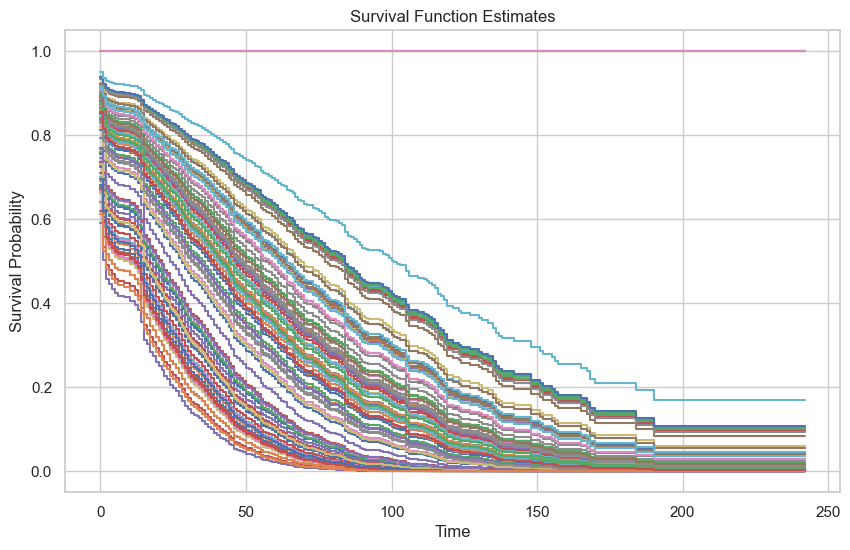

In [37]:
# Plotting the survival function for the first individual in test_X
plt.figure(figsize=(10, 6))
for i in range(survival_function.shape[1]):  # Loop through each individual
    plt.step(survival_function.index, survival_function.iloc[:, i], where="post", label=f'Individual {i+1}')
plt.title('Survival Function Estimates')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.show()

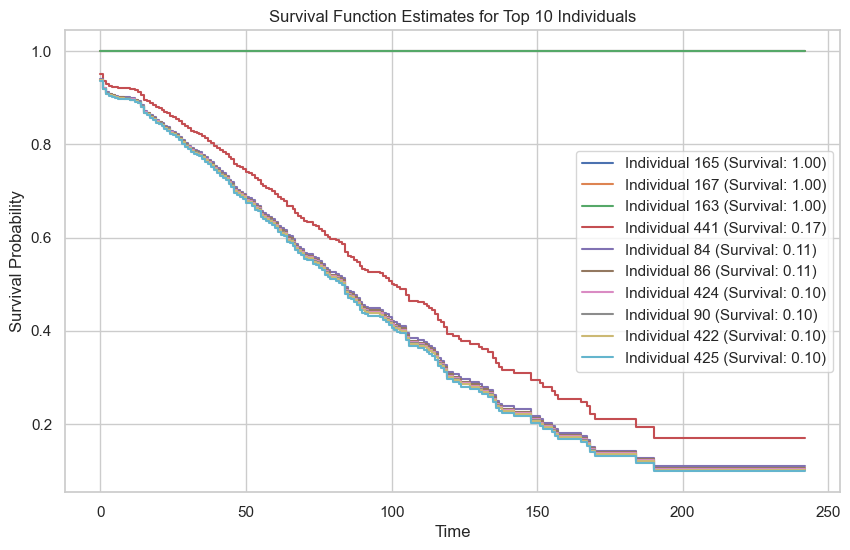

In [38]:
# Extract the last row of survival probabilities
last_row = survival_function.iloc[-1]

# Identify the indices of the 10 highest survival probabilities
top_10 = last_row.nlargest(10)

# Plotting the survival function for the top 10 individuals
plt.figure(figsize=(10, 6))
for index in top_10.index:
    plt.step(survival_function.index, survival_function[index], where="post", 
             label=f'Individual {index} (Survival: {top_10[index]:.2f})')

plt.title('Survival Function Estimates for Top 10 Individuals')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

It seems like there are 3 patiënts completely survive it. Could be use to verify with the original data to see if it was predicted right. 

In [39]:
print(df_combined[165:166]["survival_time_(weeks)"])
print(df_combined[167:168]["survival_time_(weeks)"])
print(df_combined[163:164]["survival_time_(weeks)"])

165    na
Name: survival_time_(weeks), dtype: object
167    na
Name: survival_time_(weeks), dtype: object
163    na
Name: survival_time_(weeks), dtype: object


And indeed the model predicted those right.

Based on the literature indicating that most patients do not survive beyond 50 to 80 weeks after surgery, I created this plot to illustrate the survival probabilities for patients at 81 weeks post-surgery.

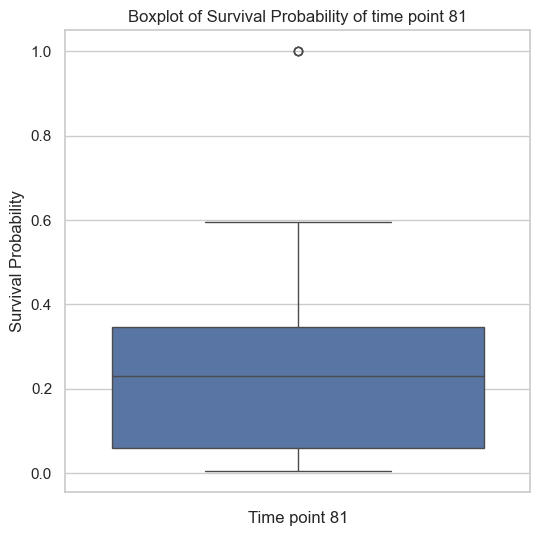

In [40]:
# Probability of surviving beyond a certain time point (e.g., 2 years)
time_point = 81.0
probabilities_beyond_time = survival_function.loc[time_point]

# Boxplot for each compartment
plt.figure(figsize=(6, 6))
sns.boxplot(data=probabilities_beyond_time)
plt.title("Boxplot of Survival Probability of time point 81")
plt.ylabel("Survival Probability")
plt.xlabel("Time point 81")
plt.show()

Approximately 75% of the data falls within the range of 0% to around 35%, while the remaining 25% is distributed between approximately 35% and 60%.

## Random Survival Forest (RSF)

The **Random Survival Forest (RSF)** is a machine learning approach tailored for survival analysis. It extends the concept of random forests by adapting it to handle censored survival data, making it a powerful tool for predicting survival outcomes in complex datasets.  
RSF is an ensemble learning method that builds multiple decision trees using bootstrapped samples of the data. At each node, the best split is determined based on survival differences rather than traditional classification or regression metrics. The final prediction combines results from all the trees, ensuring robust and accurate survival estimates.[link: ]

Behind the scenes RSF operates similarly to standard random forests but incorporates unique adaptations for survival data:  
1. **Node Splitting**: Instead of minimizing a classification or regression error, RSF splits nodes to maximize survival differences using measures like log-rank statistics.  
2. **Censoring**: RSF accommodates censored data by using non-parametric methods like Nelson-Aalen estimators to calculate cumulative hazard functions.  
3. **Ensemble Prediction**: Each tree contributes a survival prediction, which is aggregated across all trees to generate the final survival estimate.  

RSF is particularly effective for datasets with non-linear relationships, high-dimensional features, and interactions among variables. It captures complex non-linear relationships that traditional models might miss, provides measures of variable importance to identify key predictors of survival, and handles noisy and high-dimensional data effectively, making it suitable for challenging survival datasets.

RSF offers a complementary approach to traditional survival models by leveraging the strengths of machine learning to uncover hidden patterns in the data.


                                                     0
0    StepFunction(x=array([  0.,   1.,   2.,   3., ...
1    StepFunction(x=array([  0.,   1.,   2.,   3., ...
2    StepFunction(x=array([  0.,   1.,   2.,   3., ...
3    StepFunction(x=array([  0.,   1.,   2.,   3., ...
4    StepFunction(x=array([  0.,   1.,   2.,   3., ...
..                                                 ...
109  StepFunction(x=array([  0.,   1.,   2.,   3., ...
110  StepFunction(x=array([  0.,   1.,   2.,   3., ...
111  StepFunction(x=array([  0.,   1.,   2.,   3., ...
112  StepFunction(x=array([  0.,   1.,   2.,   3., ...
113  StepFunction(x=array([  0.,   1.,   2.,   3., ...

[114 rows x 1 columns]


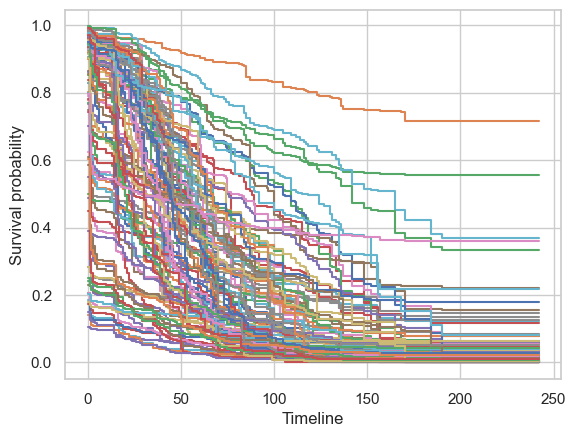

In [ ]:
# Make an RSF-model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)

# Train the model
rsf.fit(train_X, train_y)

# Make predictions
pred_survival = rsf.predict_survival_function(test_X)

# Visualize the predictions of the patients
import matplotlib.pyplot as plt
for i, surv_func in enumerate(pred_survival):  
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Patient {i+1}")
plt.ylabel("Survival probability")
plt.xlabel("Timeline")
plt.show()

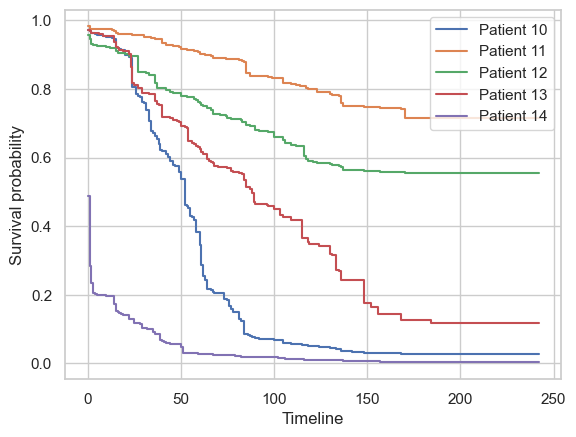

In [42]:
# Make an RSF-model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)

# Train the model
rsf.fit(train_X, train_y)

# Make predictions
pred_survival = rsf.predict_survival_function(test_X)

# Visualize the predictions of number 10 to 14 random patients
import matplotlib.pyplot as plt
for i, surv_func in enumerate(pred_survival[10:15]):  
    plt.step(surv_func.x, surv_func.y, where="post", label=f"Patient {i+10}")
plt.ylabel("Survival probability")
plt.xlabel("Timeline")
plt.legend()
plt.show()

This code demonstrates the model's predictive performance.

In [43]:
from sksurv.metrics import concordance_index_censored

c_index = concordance_index_censored(test_y['event'], test_y['time'], rsf.predict(test_X))
print(f"C-index: {c_index}")

C-index: (0.6907550910073887, 3833, 1716, 0, 102)


The first number indicates that the model is correct approximately 69.08% of the time.

## Kaplan-Meier Fitter
The **Kaplan-Meier Fitter** is a non-parametric model used to estimate survival probabilities over time. It is one of the simplest and most widely used methods in survival analysis, providing an intuitive way to visualize survival curves and compare different groups.[link: ]

The Kaplan-Meier method calculates the probability of survival at each time point, accounting for censored data. It generates a stepwise survival curve, with each step representing an event (e.g., death, relapse). This curve provides a clear visualization of survival probabilities over time.

The Kaplan-Meier estimator is defined as:  
\[
\hat{S}(t) = \prod_{t_i \leq t} \left(1 - \frac{d_i}{n_i}\right)
\]  
Where:  
- \(\hat{S}(t)\): Estimated survival probability at time \(t\)  
- \(t_i\): Time of an event  
- \(d_i\): Number of events (e.g., deaths) at \(t_i\)  
- \(n_i\): Number of individuals at risk just before \(t_i\)  

The survival curve is constructed by multiplying the probability of survival at each time point, considering only those who are still at risk. It provides clear, stepwise survival curves that are easy to interpret, allows for the comparison of survival between different groups using methods like the log-rank test, and effectively handles censored data to ensure accurate survival estimates even when follow-up is incomplete. 

The Kaplan-Meier Fitter is an essential tool for understanding survival data, offering a simple yet powerful way to gain insights into survival probabilities and differences between groups.

This first one is for all the patients at once. The second one is for specific age groups.

<Axes: xlabel='timeline'>

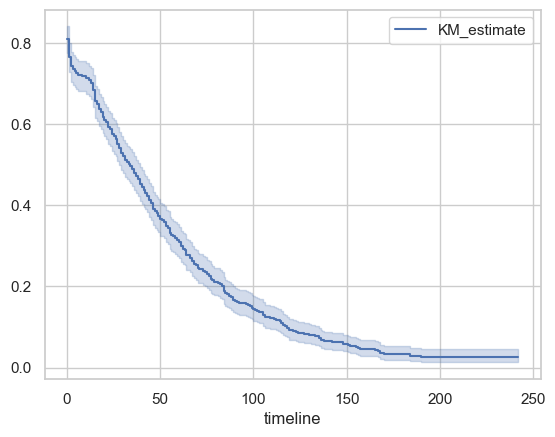

In [67]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(processed_data['time'], event_observed=processed_data['event'])
kmf.plot_survival_function()

I created a new column that categorizes patients into age groups, ranging from 0 to 110 years in 10-year intervals. First, the visualization shows how often each age group appears in the dataset. Then, a Kaplan-Meier survival analysis is applied to predict survival probabilities based on these age groups.

In [73]:
df = processed_data.copy()

# Create age groups
bins = range(0, 110, 10)
labels = [f"{i}-{i+10}" for i in bins[:-1]]
df['age_group'] = pd.cut(df['age_at_surgery_(years)'], bins=bins, labels=labels, right=False)


C:\Users\aimee\AppData\Local\Temp\ipykernel_39668\2971290721.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts = df.groupby(['age_group', 'event']).size().unstack(fill_value=0)


<Figure size 1200x600 with 0 Axes>

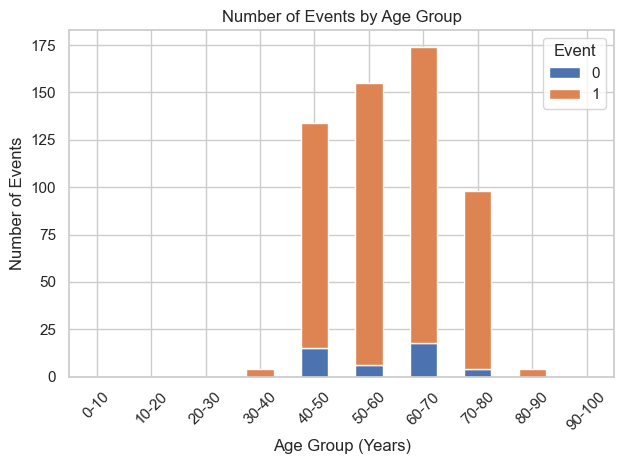

In [74]:
# Count events in each age group
event_counts = df.groupby(['age_group', 'event']).size().unstack(fill_value=0)

# Plotting
plt.figure(figsize=(12, 6))
event_counts.plot(kind='bar', stacked=True)
plt.title('Number of Events by Age Group')
plt.xlabel('Age Group (Years)')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.legend(title='Event', labels=['0', '1'])
plt.tight_layout()
plt.show()

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


C:\Users\aimee\AppData\Local\Temp\ipykernel_39668\1147759274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['time'] = pd.to_numeric(group_data['time'], errors='coerce')
C:\Users\aimee\AppData\Local\Temp\ipykernel_39668\1147759274.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_data['event'] = pd.to_numeric(group_data['event'], errors='coerce')
C:\Users\aimee\AppData\Local\Temp\ipykernel_39668\1147759274.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

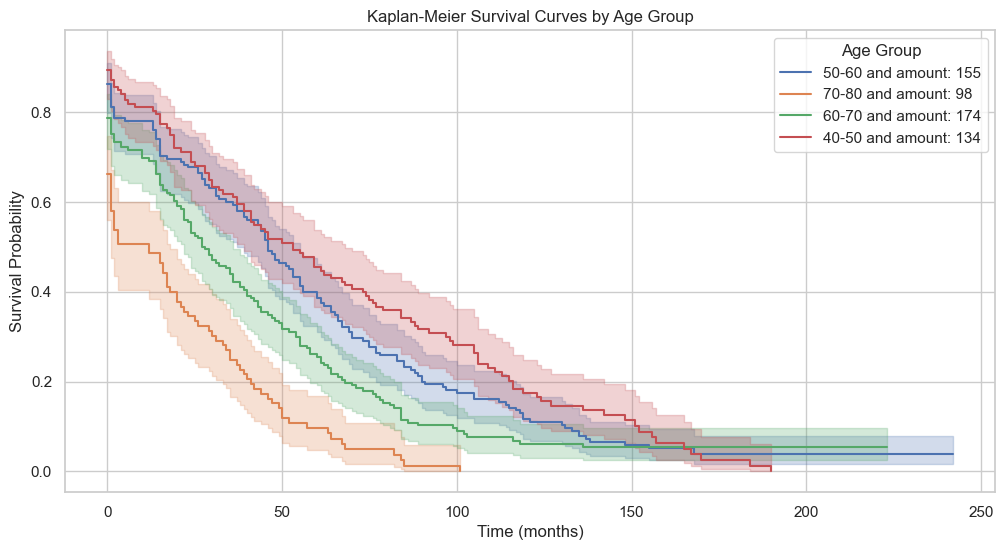

In [76]:
# Plotting Kaplan-Meier curves for each age group
plt.figure(figsize=(12, 6))
kmf = KaplanMeierFitter()

for age_group in df['age_group'].unique():
    group_data = df[df['age_group'] == age_group]
    amount = group_data["age_group"].count()
    print(type(amount))

    # Check if group_data is not empty
    if not group_data.empty and amount >= 10:
        # Ensure 'time' and 'event' are numeric
        group_data['time'] = pd.to_numeric(group_data['time'], errors='coerce')
        group_data['event'] = pd.to_numeric(group_data['event'], errors='coerce')
        
        # Drop any rows with NaN values in 'time' or 'event'
        group_data = group_data.dropna(subset=['time', 'event'])
        
        # Fit the Kaplan-Meier model
        kmf.fit(durations=group_data['time'], event_observed=group_data['event'], label=f"{str(age_group)} and amount: {amount}")
        kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curves by Age Group")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend(title="Age Group")
plt.show()

Comparison of age groups:

* The 40-50 age group (red curve) has the highest survival probability at the beginning but declines steadily over time.
* The 50-60 age group (blue curve) follows closely behind, with a similar pattern.
* The 60-70 age group (green curve) has a lower survival probability than the younger groups, indicating a higher risk.
* The 70-80 age group (orange curve) exhibits the lowest survival probability, showing a steeper decline, meaning that older individuals tend to have worse survival outcomes.

---

## Reflection

### Goals and Achievements  
This project set out to explore survival prediction for patients who have undergone surgery to remove glioblastomas, focusing on creating a proof of concept and experimenting with different models suitable for this purpose. The primary aim was to evaluate whether survival prediction models could be effectively applied to this type of data and to identify potential avenues for future improvement.  

One of the most significant achievements was successfully implementing and running the Cox proportional hazards model, which required addressing numerous data-related challenges. This process involved extensive data handling and preprocessing, such as transforming categorical variables into numeric forms and resolving issues with specific columns, like Rationale_rating, which contained a large variety of unique data points. Additionally, implementing the Random Survival Forest (RSF) model was another milestone, as it provided a different perspective on the problem and allowed for a comparison of model performance.

The results, measured using the concordance index, were promising for a preliminary attempt: the Cox model achieved a c-index of 0.66, while the RSF model slightly outperformed it with a c-index of 0.6907. These results, although not highly accurate, were a good starting point considering that the analysis was limited to dataframes containing tabular data and did not yet incorporate MRI images or extensive hyperparameter tuning. This initial exploration provided a solid foundation for further experimentation and development.

---

### Challenges and Learning Experiences  
The journey to achieve these results was not without its challenges. Preparing the dataset for modeling proved to be one of the most time-consuming and complex tasks. Many columns in the dataset were categorical, requiring transformation into numeric formats before they could be used by the models. This was particularly difficult for columns like Rationale_rating, which exhibited high variability and a broad range of unique values. 

Unexpected patterns in the dataset also emerged during this process, such as the observation that some columns with high collinearity and low variance appeared to have a disproportionate influence on the prediction of survival outcomes. This raised questions about the reliability of certain features and underscored the importance of careful feature selection and engineering.

Another key challenge was related to the exploratory data analysis (EDA). One notable finding was that the tumor’s edema volume was often larger than the combined volume of enhancing and non-enhancing components, which could have implications for survival prediction. However, no strong trends or relationships were uncovered during the EDA that directly influenced the modeling approach, suggesting that more in-depth analysis is needed.

---

### Future Improvements  
This project serves as a proof of concept, but there are several opportunities for improvement that could significantly enhance the model’s performance and applicability.  

1. **Enhanced EDA**  
   A deeper dive into the dataset could reveal more meaningful relationships between variables. For example, examining correlations between tumor volume components, patient demographics, and survival times could provide valuable insights for feature selection and model optimization. 

2. **Inclusion of MRI Data**  
   Incorporating MRI scans into the modeling process has the potential to provide richer context and improve predictions. Preprocessing MRI data would likely involve steps such as image normalization, segmentation to extract tumor regions(which probably already happend), and feature extraction using techniques like radiomics or convolutional neural networks (CNNs). Combining these image-derived features with tabular data could result in a more holistic and accurate model.

3. **Feature Engineering**  
   Further feature engineering, such as creating derived features, handling missing values more effectively, and exploring interactions between variables, could improve model performance. For example, combinding tumor volume ratios with patient-specific factors like age or prior treatments might provide more predictive power.

4. **Hyperparameter Tuning**  
   Systematic tuning of hyperparameters for both the Cox model and RSF could lead to better optimization of the models. Techniques like grid search, random search, or Bayesian optimization could be employed to identify the best configurations.

5. **Experimentation with Advanced Models**  
   Beyond Cox and RSF, exploring advanced machine learning models, such as ensemble methods or deep learning architectures, could provide better performance. Techniques like stacking or blending could also be used to combine the strengths of multiple models.

6. **Data Augmentation**  
   Searching for additional data sources to augment the existing dataset could help mitigate the limitations posed by the current dataset’s size and variability. External datasets with similar characteristics could be used to validate findings and improve the model’s generalizability.

---

### Vision for a Clinical Tool  
The ultimate improvement of this project is to put the model(s) in a tool that can assist clinicians in predicting survival outcomes for glioblastoma patients post-surgery. Such a tool could include:  

1. **User Interface**  
   A dashboard where clinicians can input patient data and MRI scans to receive predictions in an intuitive and accessible format. For example the pre-surgery with a estimate on what can be remove with surgery to help decide for the patient if it is worth getting the surgery or not but also including complications it might include beacuse per part of the brain it might be different. Another example is pre- and post-surgery to predict the estimasation of survival in weeks with the possibility to keep track of it so if there is an new MRI it will estimate it again.

2. **Report Generation**  
   Automated reports summarizing survival predictions, key influencing factors, and confidence intervals could support clinical decision-making and discussions with patients.  

3. **Visualization**  
   Graphical representations of survival curves, feature importance, and MRI scan overlays could help make the predictions more interpretable.  

---

### Broader Impact  
This project has highlighted the potential for survival prediction models to contribute to personalized care for glioblastoma patients. By addressing challenges in data preprocessing, feature engineering, and model development, the project has laid the groundwork for more sophisticated analyses. The lessons learned here, including the importance of handling real-world data challenges and iterating on modeling approaches, are invaluable for future work in this domain. 

Moreover, the ultimate vision of creating a clinical tool emphasizes the practical relevance of this research, with the potential to improve decision-making and patient outcomes in a meaningful way. While this is just the beginning, it represents a promising step toward leveraging data-driven approaches in the fight against glioblastoma.

